# Matching and Grouping

This notebook is a simple example of using [minimum-cost maximum-flow](https://en.wikipedia.org/wiki/Minimum-cost_flow_problem) to solve asiment problem involving both matching and grouping. In this example, we'll use a collected survey from students to assign each a paper and group.  
*Survey Excerpt:*
> Rate the listed papers below in proportion to your preference in presenting it; i.e. weight papers you love higher than those you dislike. We'll then use a matching algorithm using minimum-cost maximum-flow to optimize for individual preferences and global optimum.

> Note: that it's in your best interest to pick the weights that reflect your true preference, as setting everything either artificially high or low will reduce your influence in adjusting the matching in your favor. Being more decisive will give you more influence, while at the same time, choosing multiple will also help to hedge your bets.

> After you submit, you'll be able to view the current group results and come back to make changes in your selection based on any trends in supply & demand for papers you may be bidding for.

In the survey students rated all papers from 1 to 10 with ratings reflecting preference, not necessarily fixed sorted rank. The code below shows how the data is reformulated into a graph representation with the optimal flow used to generate the eventual assignment.

### Import dependencies

In [1]:
import pandas as pd # for haldeling dataframes
import networkx as nx # for handeling graphs
import matplotlib.pyplot as plt # for ploting visualizations

#plot figures in notebook
%matplotlib inline

### Set parameters

In [2]:
response_file = "data/test_input_small.csv" # example input data from servey
num_of_groups = 2 # example data includes 10 students and 5 papers, so 2 groups must be formed

### Create graph

In [3]:
df = pd.read_csv(response_file) # read file
G = nx.DiGraph() # create a direction graph
G.add_nodes_from(df['GTID'], bipartite=1) # add students to the graph using IDs, bipartite set for plotting

papers = list(df.keys()) # get the list of keys that make up the column
keys = ['Timestamp','First Name','Last Name','GTID']
papers = [x for x in papers if x not in keys] # filter dataframe keys to just names of papers
G.add_nodes_from(papers, bipartite=0) # add the papers to the graph

### Load graph

In [4]:
for index, row in df.iterrows(): # loop over dataframe
    for paper in papers: # for the ratting of each paper given by each student
        # add directional edge with inverted 'cost'
        G.add_edges_from([(row['GTID'], paper, {'capacity': 1, 'weight': 10-row[paper]})])

### Draw graph

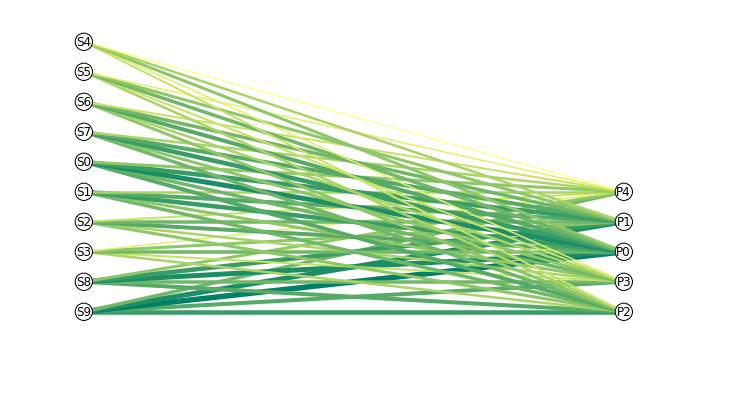

In [5]:
# set pose given bipartite attribute
X, Y = nx.bipartite.sets(G)
pos = dict()
pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
pos.update( (n, (10, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2

# set edge widths and color map to reflect weight
edge_width = []
edge_colors = []
edge_cmap = plt.cm.summer
for (u,v,d) in G.edges(data=True):
    edge_width.append((10-d['weight'])/2.0)
    edge_colors.append(d['weight'])

# draw current graph with labels
fig = plt.figure(figsize=[10,5])
nx.draw(G, pos=pos, width = edge_width, edge_color=edge_colors, node_color='w', with_labels=True, arrows=False, edge_cmap=edge_cmap)
plt.show()

In the above figure, the relation of strongly prefered papers is represented by a thicker and greener edge between a Student and Paper node.

### Add source and sink for flow

In [6]:
G.add_node('S') # add super source
G.add_node('P') # and super sink

# connect super sink
for paper in papers:
    # remembering the num of students assined to each paper is the same as the num of groups
    G.add_edges_from([(paper, 'P', {'capacity': num_of_groups, 'weight': 0})])

# connect super source
for index, row in df.iterrows():
    # remembering each edge corresponds just one student
    G.add_edges_from([('S', row['GTID'], {'capacity': 1, 'weight': 0})])

### Solve for max flow with min cost

In [7]:
assignments = nx.max_flow_min_cost(G, 'S', 'P') # leverage networkx library for out linear programming solver
mincost = nx.cost_of_flow(G, assignments) # calculate the cost out of curiosity
print"mincost: ", mincost
assignments

mincost:  35


{'P': {},
 'P0': {'P': 2},
 'P1': {'P': 2},
 'P2': {'P': 2},
 'P3': {'P': 2},
 'P4': {'P': 2},
 'S': {'S0': 1,
  'S1': 1,
  'S2': 1,
  'S3': 1,
  'S4': 1,
  'S5': 1,
  'S6': 1,
  'S7': 1,
  'S8': 1,
  'S9': 1},
 'S0': {'P0': 0, 'P1': 0, 'P2': 0, 'P3': 1, 'P4': 0},
 'S1': {'P0': 1, 'P1': 0, 'P2': 0, 'P3': 0, 'P4': 0},
 'S2': {'P0': 0, 'P1': 0, 'P2': 0, 'P3': 0, 'P4': 1},
 'S3': {'P0': 0, 'P1': 1, 'P2': 0, 'P3': 0, 'P4': 0},
 'S4': {'P0': 0, 'P1': 0, 'P2': 1, 'P3': 0, 'P4': 0},
 'S5': {'P0': 0, 'P1': 0, 'P2': 0, 'P3': 1, 'P4': 0},
 'S6': {'P0': 1, 'P1': 0, 'P2': 0, 'P3': 0, 'P4': 0},
 'S7': {'P0': 0, 'P1': 1, 'P2': 0, 'P3': 0, 'P4': 0},
 'S8': {'P0': 0, 'P1': 0, 'P2': 1, 'P3': 0, 'P4': 0},
 'S9': {'P0': 0, 'P1': 0, 'P2': 0, 'P3': 0, 'P4': 1}}

**Note:** that each paper recives a non zero flow equal to the respective number of students assigened.

### Recover assiment from flow

In [8]:
# creat list for paper and group assinment
assigned = []
grouped = []
# as well as a dictionary to keep track of simple group counter 
group_count = {}

for index, row in df.iterrows(): # loop over students
    assignment = assignments[row['GTID']]
    for node, flow in assignment.iteritems():
        if(flow == 1):
            paper = node # get the name for assined paper
    group_count[paper] = group_count.get(paper, 0) + 1 # get/increment the group counter for paper
    assigned.append(paper)
    grouped.append(group_count[paper])

# add assinments to dataframe
df['Assigned'] = pd.Series(assigned, index=df.index)
df['Group'] = pd.Series(grouped, index=df.index)

### Save relevent output

In [9]:
dff = df.drop(papers + ['Timestamp','GTID'], 1) # Keep just the Names and assinments
dff.to_csv('data/test_output.csv',index=False) # Save to disk and ditch the index column